# Import libraries


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load the UCI-HAR dataset

In [25]:
train_data = pd.read_csv("X_train.txt", delim_whitespace=True, header=None)
train_labels = pd.read_csv("y_train.txt", header=None, names=['Activity'])

test_data = pd.read_csv("X_test.txt", delim_whitespace=True, header=None)
test_labels = pd.read_csv("y_test.txt", header=None, names=['Activity'])


# Merge features and labels

In [26]:
train_data['Activity'] = train_labels['Activity']
test_data['Activity'] = test_labels['Activity']

# Combine training and test sets

In [27]:
combined_data = pd.concat([train_data, test_data], ignore_index=True)

In [28]:
# Standardize features
scaler = StandardScaler()
combined_data.iloc[:, :-1] = scaler.fit_transform(combined_data.iloc[:, :-1])

# Encode activity labels
label_encoder = LabelEncoder()
combined_data['Activity'] = label_encoder.fit_transform(combined_data['Activity'])

# Convert labels to one-hot encoding
combined_data = pd.get_dummies(combined_data, columns=['Activity'])

In [29]:
# Display information about the dataset
print("Dataset Info:")
print(combined_data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 567 entries, 0 to Activity_5
dtypes: bool(6), float64(561)
memory usage: 44.1 MB
None


# Reshape for CNN-GRU Model

In [30]:
import numpy as np
# Separate features and labels
X = combined_data.iloc[:, :-6]  # Exclude one-hot encoded activity labels
y = combined_data.iloc[:, -6:]  # Extract one-hot encoded activity labels
# Reshape data for CNN-GRU model
X_reshaped = X.values.reshape((X.shape[0], 1, X.shape[1]))
y_array = np.array(y)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_array, test_size=0.2, random_state=42)

# Augmentation

In [31]:
import numpy as np

# Assuming X_train has shape (number of samples, time steps, features)
# You can adjust the parameters based on your dataset and requirements

def add_random_noise(data, noise_factor=0.01):
    """
    Add random noise to the input data.
    """
    noise = np.random.normal(loc=0, scale=noise_factor, size=data.shape)
    return data + noise

# Number of augmented samples to generate
num_augmented_samples = 500

# Create augmented samples
augmented_samples = []
for _ in range(num_augmented_samples):
    # Randomly select a sample from the original dataset
    random_index = np.random.randint(0, len(X_train))
    original_sample = X_train[random_index]

    # Apply data augmentation (add random noise in this case)
    augmented_sample = add_random_noise(original_sample)

    # Append the augmented sample to the list
    augmented_samples.append(augmented_sample)

# Convert the list of augmented samples to a NumPy array
augmented_samples = np.array(augmented_samples)

# Concatenate the original dataset with the augmented samples
X_train_augmented = np.concatenate([X_train, augmented_samples], axis=0)
y_train_augmented = np.concatenate([y_train] * (num_augmented_samples + 1), axis=0)


# Segmentation

In [32]:
import numpy as np

def segment_data(data, labels, window_size, overlap):
   

    num_samples, num_time_steps, num_features = data.shape
    step_size = int(window_size * (1 - overlap))

    # Calculate the number of windows
    num_windows = int((num_time_steps - window_size) / step_size) + 1

    # Initialize arrays to store segmented data and labels
    segmented_data = np.zeros((num_samples * num_windows, window_size, num_features))
    segmented_labels = np.zeros(num_samples * num_windows)

    # Iterate through each sample
    for i in range(num_samples):
        sample_data = data[i]
        label = labels[i]

        # Iterate through each window
        for j in range(num_windows):
            start = j * step_size
            end = start + window_size

            # Extract the window from the original data
            window_data = sample_data[start:end, :]

            # Store the segmented data and label
            index = i * num_windows + j
            segmented_data[index] = window_data
            segmented_labels[index] = label

    return segmented_data, segmented_labels

# Assuming X_train and y_train are your training data and labels
# Specify the window size and overlap
window_size = 128  # Adjust as needed
overlap = 0.5  # Adjust as needed

# Segment the training data
X_train_segmented, y_train_segmented = segment_data(X_train, y_train, window_size, overlap)

# Linear Interpolation

In [33]:
import pandas as pd
import numpy as np
# Flatten the time steps for each sample
X_train_flattened = X_train.reshape((X_train.shape[0], -1))

# Convert to a DataFrame for easier interpolation
df_train = pd.DataFrame(X_train_flattened)

# Perform linear interpolation
df_train.interpolate(method='linear', axis=1, inplace=True)

# Reshape the interpolated data back to the original shape
X_train_interpolated = df_train.values.reshape(X_train.shape)

# Check for NaN values after interpolation
if np.isnan(X_train_interpolated).any():
    print("Warning: NaN values still present after interpolation.")


# Normalization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


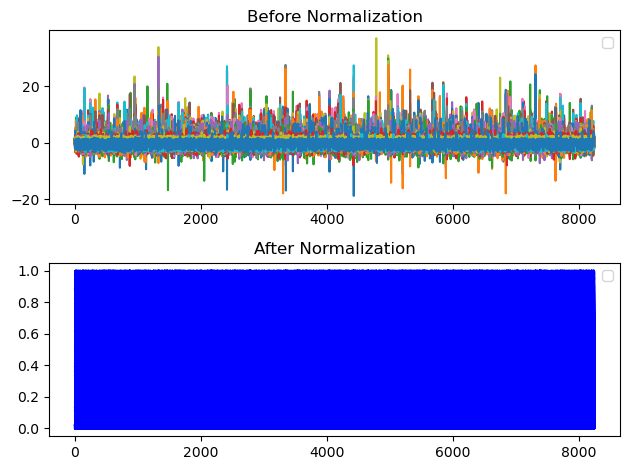

In [34]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
df_train_normalized = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)

# Plot the original and normalized data for comparison
plt.subplot(2, 1, 1)
plt.plot(df_train)
plt.title('Before Normalization')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df_train_normalized,color='blue')
plt.title('After Normalization')
plt.legend()

plt.tight_layout()
plt.show()


Normalized Data:
   Feature1  Feature2
0       0.0       0.8
1       0.2       0.6
2       0.4       0.4
3       0.6       1.0
4       0.8       0.0

Normalized Data with Target Variable:
   Feature1  Feature2            Activity
0       0.0       0.8             Walking
1       0.2       0.6             Sitting
2       0.4       0.4              Laying
3       0.6       1.0  Walking Downstairs
4       0.8       0.0            Standing


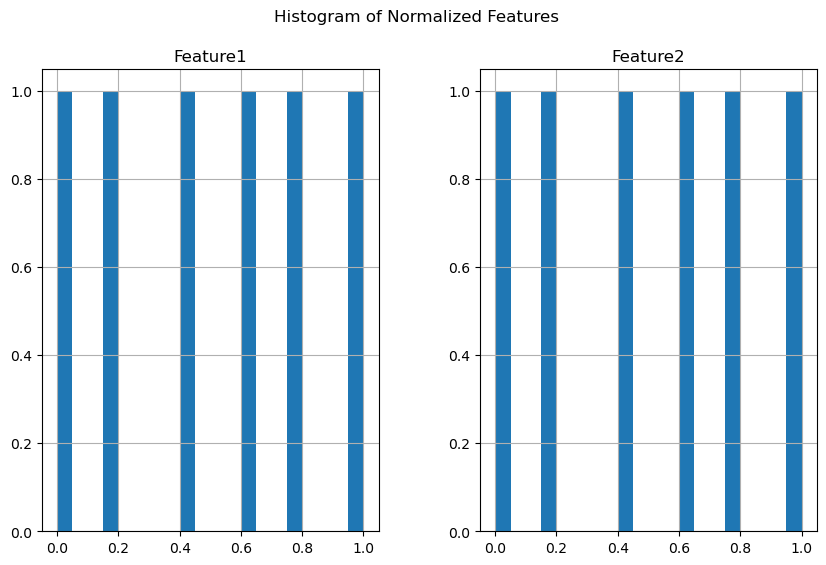

In [35]:
# Assuming df_train is the original dataset
# Replace this with  actual dataset or provide its definition

# Create a hypothetical DataFrame for illustration
data = {'Feature1': [1, 2, 3, 4, 5, 6],
        'Feature2': [5, 4, 3, 6, 1, 2],
        'Activity': ['Walking', 'Sitting', 'Laying', 'Walking Downstairs','Standing', 'Walking Upstairs']}

df_train = pd.DataFrame(data)

# Separate the features and the target variable
X = df_train.drop('Activity', axis=1)
y = df_train['Activity']

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Display the first few rows of the normalized dataset
print("\nNormalized Data:")
print(X_normalized.head())

# Concatenate the normalized features with the target variable
df_normalized = pd.concat([X_normalized, y], axis=1)

# Display the first few rows of the dataset with normalized features
print("\nNormalized Data with Target Variable:")
print(df_normalized.head())

# Optionally, you can visualize the distribution of the normalized features
X_normalized.hist(bins=20, figsize=(10, 6))
plt.suptitle("Histogram of Normalized Features")
plt.show()

# Build CNN -GRU 

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GRU, Dense, Flatten
model = Sequential()

In [37]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Flatten, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation

from tensorflow.keras.layers import Layer, Concatenate

class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        # Use the same input as both query and value
        query_value = inputs
        attention = Concatenate()([query_value, query_value])  # Concatenate query and value
        return attention

    def compute_output_shape(self, input_shape):
        return input_shape

model = Sequential()

# Add Conv1D layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=((X_train.shape[1], X_train.shape[2])), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add GRU layer (return_sequences=True is important)
model.add(GRU(50, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))


# Add Self-Attention layer
model.add(SelfAttention())

#Add GRU layer
model.add(GRU(50, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Flatten the output
model.add(Flatten())

# Fully connected layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(6, activation='softmax'))

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 32)             53888     
                                                                 
 batch_normalization_1 (Batc  (None, 1, 32)            128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1, 32)             0         
                                                                 
 gru_2 (GRU)                 (None, 1, 50)             12600     
                                                                 
 dropout_5 (Dropout)         (None, 1, 50)             0         
                                                                 
 self_attention_1 (SelfAtten  (None, 1, 100)           0         
 tion)                                                

In [38]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
          batch_size=500,
          epochs=100,
          validation_data=(X_test, y_test),
          verbose=1)

Epoch 1/100
17/17 [==============================] - 10s 304ms/step - loss: 3.7060 - accuracy: 0.2965 - val_loss: 3.1322 - val_accuracy: 0.4951
Epoch 2/100
17/17 [==============================] - 0s 18ms/step - loss: 2.7719 - accuracy: 0.4712 - val_loss: 2.2200 - val_accuracy: 0.5087
Epoch 3/100
17/17 [==============================] - 0s 18ms/step - loss: 2.0551 - accuracy: 0.5631 - val_loss: 1.6545 - val_accuracy: 0.7393
Epoch 4/100
17/17 [==============================] - 0s 17ms/step - loss: 1.5794 - accuracy: 0.6547 - val_loss: 1.2775 - val_accuracy: 0.8252
Epoch 5/100
17/17 [==============================] - 0s 16ms/step - loss: 1.2283 - accuracy: 0.7505 - val_loss: 0.9772 - val_accuracy: 0.8782
Epoch 6/100
17/17 [==============================] - 0s 17ms/step - loss: 0.9801 - accuracy: 0.8068 - val_loss: 0.7470 - val_accuracy: 0.9422
Epoch 7/100
17/17 [==============================] - 0s 17ms/step - loss: 0.7776 - accuracy: 0.8608 - val_loss: 0.5921 - val_accuracy: 0.9485
Epoc

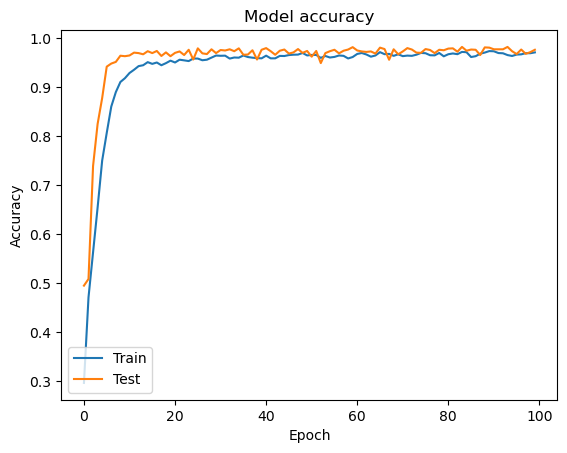

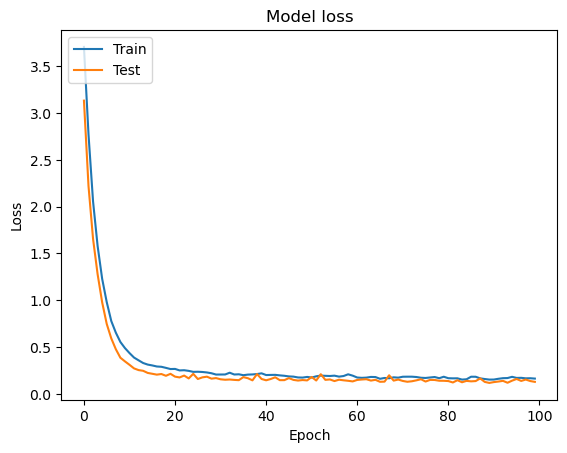

In [39]:
name = 'model'
model.save(name+'.h5')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower left')
plt.savefig(name+'_acc.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(name+'_loss.png')
plt.show()

In [40]:
from sklearn.metrics import confusion_matrix
import numpy as np


score = model.evaluate(X_test, y_test)
print("Accuracy: ", score[1])
print("Loss: ", score[0])
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1)))

65/65 [==============================] - 0s 3ms/step - loss: 0.1276 - accuracy: 0.9767
Accuracy:  0.9766990542411804
Loss:  0.12757857143878937
65/65 [==============================] - 1s 2ms/step
[[367   1   1   0   0   0]
 [  0 268   2   0   0   0]
 [  0   0 284   0   0   0]
 [  0   0   0 358  19   0]
 [  0   0   0  21 333   0]
 [  0   0   0   4   0 402]]


65/65 [==============================] - 0s 3ms/step


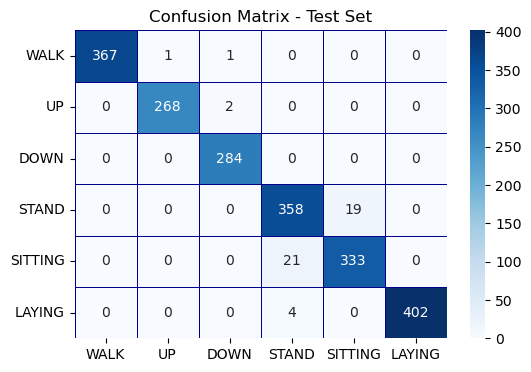

In [48]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_true_test contains your true labels for the test set
y_true_test = np.argmax(y_test, axis=1)

# Assuming y_pred_test_classes is the predicted labels for the test set
y_pred_test = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Compute confusion matrix for the test set
confusion_matrix_test = confusion_matrix(y_true_test, y_pred_test_classes)

# Create a DataFrame from the confusion matrix
confusion_matrix_df_test = pd.DataFrame(data=confusion_matrix_test,
                                        columns=['WALK', 'UP', 'DOWN', 'STAND', 'SITTING', 'LAYING'],
                                        index=['WALK', 'UP', 'DOWN', 'STAND', 'SITTING', 'LAYING'])

# Plot the heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_df_test, annot=True, fmt='d', cmap="Blues", linecolor="DarkBlue", linewidths=0.55)
plt.title('Confusion Matrix - Test Set')
plt.show()

In [49]:
from sklearn.metrics import classification_report

# Generate classification report from the confusion matrix
classification_report_test = classification_report(y_true_test, y_pred_test_classes, target_names=['WALK', 'UP', 'DOWN', 'STAND', 'SITTING', 'LAYING'])

print("Classification Report - Test Set:")
print(classification_report_test)


Classification Report - Test Set:
              precision    recall  f1-score   support

        WALK       1.00      0.99      1.00       369
          UP       1.00      0.99      0.99       270
        DOWN       0.99      1.00      0.99       284
       STAND       0.93      0.95      0.94       377
     SITTING       0.95      0.94      0.94       354
      LAYING       1.00      0.99      1.00       406

    accuracy                           0.98      2060
   macro avg       0.98      0.98      0.98      2060
weighted avg       0.98      0.98      0.98      2060

